<a href="https://www.kaggle.com/code/abhilashsampath/amazon-review-spam-detection?scriptVersionId=138112592" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Amazon review spam detection

# Load data utilizing Apache SPARK 

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285411 sha256=81ebb4d8c288573ece635fe341dd26b228b678fc5e1c3adb2c2aedea3b55e59d
  Stored in directory: /root/.cache/pip/wheels/b7/8e/8f/ba5d017af5f502964eb1358e1d496a8519de1645936b01810e
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5


In [4]:


from pyspark.sql import SparkSession

# Create a SparkSession

spark = SparkSession.builder \
    .appName("Amazon Review Spam Detection") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.memoryOverhead", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()


# Load the JSON dataset
df = spark.read.json("/kaggle/input/amazon-product-review-spam-and-non-spam/Electronics/Electronics.json")
# df = spark.read.json("/kaggle/input/amazon-product-review-spam-and-non-spam/Toys_and_Games/Toys_and_Games.json")
# Show the first few rows of the DataFrame
df.show()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/28 03:22:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|{5a13242d741a2384...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

# Data preprocessing

* ## Understanding the datatypes for each vector

In [6]:
df.printSchema()


root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()

# for each unique 'label', show a few records
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)  

+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|                 _id|      asin|   category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|      reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|               JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    1.0|It never worked. ...|04 29, 2013|A2NWSAGRHCP8N5|       bowmans2007| absolutely horrible|    1367193600|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [4, 4]|    1.0|Do not waste your...|04 18, 2012|A1GI0U4ZRJA8WN|         Truthfull|TERRIBLE DO

# Phase1 Data Cleaning

## I Removing special characters from id

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace


cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

## II Dropping unnecessary columns

In [9]:
cleaned_df = cleaned_df.drop( 'category') #,'asin' , 'reviewerID', 'reviewerName') 
cleaned_df.show()

+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341100800|
|5a13242d741a2384e...|043988

## III Renaming few Columns for QoL

In [10]:
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")
             


In [11]:
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341

## IV Placing the number of votes received as a metric from Helpful

In [12]:
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 

## V Modifying the originally 'helpful' column to a float value showcasing No. of people who found it helpful among the total people that viewed it

In [13]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  # or any other value that makes sense in the context
    except:
        return None

# UDF registration
ratio_udf = udf(helpful_ratio, FloatType())

# Apply the UDF to the DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))



In [14]:
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [15]:
cleaned_df.columns

['id',
 'asin',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

## VI Removing special characters  and converting them to just lowercase

> 1. from reviewText

In [16]:
from pyspark.sql.functions import col, lower, regexp_replace

cleaned_df = cleaned_df.withColumn("reviewText", lower(col("reviewText")))\
                 .withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]", ""))


> 2. from Summary

In [17]:

cleaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))


In [18]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|      

## VII Evaluating Review and Summary Length 

In [19]:
from pyspark.sql.functions import length

cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|         147|           13|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gib

## VIII Evaluating Wether a review was posted on weekend or not

In [20]:
from pyspark.sql.functions import col, dayofweek, when

cleaned_df = cleaned_df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))

cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))


In [21]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|      null|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|         147|           13|        0|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|

## IX  Creating Product Popularity from its review count,

In [22]:
cleaned_df = cleaned_df.withColumn('reviewLength', length(cleaned_df['reviewText']))
cleaned_df = cleaned_df.withColumn('summaryLength', length(cleaned_df['summary']))
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|
+--------------------+----------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|      null|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|         147|           13|        0|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|

## X   Calculating average rating so that the model can see how far the deviation is

In [23]:
from pyspark.sql.functions import col, dayofweek, when

cleaned_df = cleaned_df.withColumn('reviewTime', col('reviewTime').cast('timestamp'))

cleaned_df = cleaned_df.withColumn('isWeekend', when(dayofweek(col('reviewTime')) > 5, 1).otherwise(0))




## XI Bucketing The helpfulTotalRatio 

In [24]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer

# calculate product popularity
product_popularity_df = cleaned_df.groupBy('asin').agg(F.count('*').alias('productPopularity'))
cleaned_df = cleaned_df.join(product_popularity_df, on='asin', how='left')

# calculate product average rating
product_avg_rating_df = cleaned_df.groupBy('asin').agg(F.avg('productRating').alias('avgProductRating'))
cleaned_df = cleaned_df.join(product_avg_rating_df, on='asin', how='left')

# create helpful ratio category
bucketizer = Bucketizer(splits=[0, 33.3, 66.6, 100], inputCol="helpfulTotalRatio", outputCol="helpfulRatioCategory")
cleaned_df = bucketizer.setHandleInvalid("keep").transform(cleaned_df)

# convert helpful ratio category from numerical to categorical
cleaned_df = cleaned_df.withColumn("helpfulRatioCategory", 
                   F.when(F.col("helpfulRatioCategory") == 0, "Low")\
                    .when(F.col("helpfulRatioCategory") == 1, "Medium")\
                    .otherwise("High"))

# create contains question column
cleaned_df = cleaned_df.withColumn('containsQuestion', (F.col('reviewText').like('%?%')).cast('integer'))


In [25]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline



fraction = 0.0001

# Downsample the dataframe
cleaned_df = cleaned_df.sample(False, fraction, seed=42)

# Preprocess the data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

feature_pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf])

feature_model = feature_pipeline.fit(cleaned_df)

dataset = feature_model.transform(cleaned_df)

cleaned_df.show()


+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+------------------+--------------------+----------------+
|      asin|                  id|class|helpfulTotalRatio|productRating|          reviewText|reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|reviewLength|summaryLength|isWeekend|productPopularity|  avgProductRating|helpfulRatioCategory|containsQuestion|
+----------+--------------------+-----+-----------------+-------------+--------------------+----------+--------------+--------------------+--------------------+--------------+-------------+------------+-------------+---------+-----------------+------------------+--------------------+----------------+
|B00004TENT|5a13242f741a2384e...|  1.0|             50.0|          5.0|64 mb on somethin...|  

In [40]:
from pyspark.storagelevel import StorageLevel


# After all the transformations
cleaned_df.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[asin: string, id: string, class: double, helpfulTotalRatio: float, productRating: double, reviewText: string, reviewTime: timestamp, reviewerID: string, reviewerName: string, summary: string, unixReviewTime: bigint, reviewUpvotes: bigint, reviewLength: int, summaryLength: int, isWeekend: int, productPopularity: bigint, avgProductRating: double, helpfulRatioCategory: string, containsQuestion: int, tokens: array<string>, filtered_tokens: array<string>, rawFeatures: vector, features: vector]

# Machine Learning Algorithms

## Logistic Regression - Input: Review Text

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Preprocess the data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the logistic regression model
lr = LogisticRegression(labelCol="class")

# Construct the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Train the model
model = pipeline.fit(cleaned_df)

# Predict on the whole dataset
predictions = model.transform(cleaned_df)

## Evaluation

In [36]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

evaluatorf1 = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(predictions)
print("f1 = %g" % f1)

# For binary classification, we can use BinaryClassificationEvaluator to get the areaUnderROC
if cleaned_df.select("class").distinct().count() == 2:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="class")
    auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    print("Area under ROC = %g" % auc)


23/06/27 22:26:51 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


Accuracy = 0.898428


23/06/27 22:52:19 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


f1 = 0.895294


23/06/27 23:01:37 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


Area under ROC = 0.940104


In [37]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert DataFrame column type from vector to float
predictionAndLabel = predictions.select("prediction", "class").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabel)

# Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()


/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:159: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,
23/06/27 23:11:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/06/27 23:11:46 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


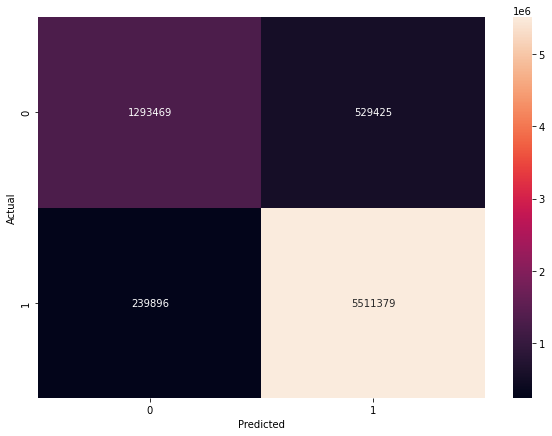

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [23]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import plotly.express as px
import pandas as pd


In [25]:
train_data, test_data = cleaned_df.randomSplit([0.7, 0.3], seed=42)
assembler = VectorAssembler(
    inputCols=['helpfulTotalRatio', 'reviewLength', 'summaryLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion'],
    outputCol='features')

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)




## Input vector : ['helpfulTotalRatio', 'reviewLength', 'summaryLength', 'isWeekend', 'productPopularity', 'avgProductRating', 'containsQuestion']

## Decision Tree 

In [27]:
from pyspark.ml.feature import VectorAssembler
dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")


model = dt.fit(train_data)





In [28]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

Test Accuracy =  0.7882822732954551


## Random Forest

In [29]:
rf = RandomForestClassifier(labelCol="class", featuresCol="features")
model = rf.fit(train_data)

In [30]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

Test Accuracy =  0.7835589229054565


## Gradient Boosted Trees

In [31]:
gbt = GBTClassifier(labelCol="class", featuresCol="features")
gbt_model = gbt.fit(train_data)

In [32]:
predictions = gbt_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")

# Compute the accuracy on the test data
accuracy = evaluator.evaluate(predictions)

print("Test Accuracy = ", accuracy)

23/06/27 21:40:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test Accuracy =  0.7936117114810973


## Input : Review Text

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

# Build the classifiers
dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
rf = RandomForestClassifier(labelCol="class", featuresCol="features")
gbt = GBTClassifier(labelCol="class", featuresCol="features")




In [27]:
model_dt = dt.fit(dataset)
predictions_dt = model_dt.transform(test_dataset)


23/06/28 03:32:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:32:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:32:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:32:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/06/28 03:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/06/28 03:33:55 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:34:44 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:34:56 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:35:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:35:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


In [32]:
# Compute the accuracy on the test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_dt)

print("Test Accuracy = ", accuracy)

23/06/28 03:37:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


Test Accuracy =  0.8192612137203166


In [33]:
model_rf = rf.fit(dataset)
predictions_rf = model_rf.transform(test_dataset)


23/06/28 03:42:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:42:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:42:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:42:34 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/06/28 03:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/06/28 03:43:25 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/06/28 03:44:14 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/06/28 03:44:30 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/06/28 03:44:47 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/06/28 03:45:05 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


In [34]:
# Compute the accuracy on the test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)

print("Test Accuracy = ", accuracy)

23/06/28 03:45:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


Test Accuracy =  0.7506596306068601


In [ ]:
model_gbt = gbt.fit(dataset)
predictions_gbt = model_gbt.transform(dataset)


23/06/28 03:49:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:49:34 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:49:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/06/28 03:50:00 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
23/06/28 03:50:49 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB
23/06/28 03:50:50 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:51:36 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:51:47 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:52:02 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:52:19 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:52:48 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/28 03:53:00 WARN DAGScheduler: Broadcasting l

In [ ]:
# Compute the accuracy on the test data
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)

print("Test Accuracy = ", accuracy)

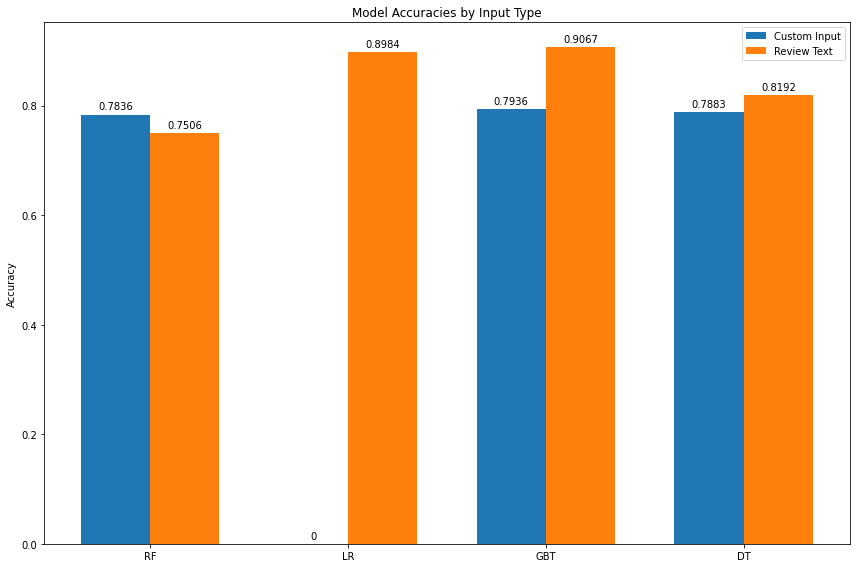

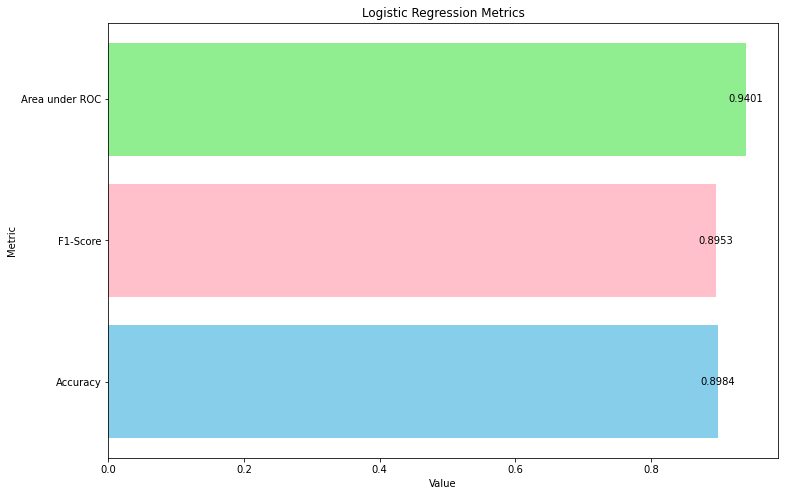

In [6]:
import matplotlib.pyplot as plt
import numpy as np

custom_input_accuracies = [0.7936, 0.7836, 0.7883]
custom_input_labels = ['GBT', 'RF', 'DT']

review_text_accuracies = [0.8984, 0.9067, 0.7506, 0.8192]
review_text_labels = ['LR', 'GBT', 'RF', 'DT']

labels = list(set(custom_input_labels + review_text_labels))

custom_input_accuracies = [custom_input_accuracies[custom_input_labels.index(l)] if l in custom_input_labels else 0 for l in labels]
review_text_accuracies = [review_text_accuracies[review_text_labels.index(l)] if l in review_text_labels else 0 for l in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width/2, custom_input_accuracies, width, label='Custom Input')
rects2 = ax.bar(x + width/2, review_text_accuracies, width, label='Review Text')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies by Input Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Separate bar chart for LR model's additional metrics
lr_metrics = [0.8984, 0.8953, 0.9401]
lr_metric_labels = ['Accuracy', 'F1-Score', 'Area under ROC']

colors = ['skyblue', 'pink', 'lightgreen']

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(lr_metric_labels, lr_metrics, color=colors)
ax.set_title('Logistic Regression Metrics')
ax.set_xlabel('Value')
ax.set_ylabel('Metric')

# Show values on bars
for i, v in enumerate(ax.patches):
    ax.text(v.get_width(), v.get_y() + v.get_height() / 2, 
             str(round(lr_metrics[i], 4)), 
             fontsize=10, ha='center', va='center')

plt.show()
